In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

We want to write an equation that converts a point in frequency-eccentricity space to a new eccentricity at a given frequency. At 0PN this is governed by keeping the following equation

$$
f(e) \propto e^{-18/19} (1-e^2)^{3/2} (304+121e^2)^{-1305/2299}.
$$

We can easily work out the constant of proportionality given the initial point in frequency-eccentricity space, however the above equation is not solvable for $e$. The current approach we have implemented is therefore to use scipy.optimize.minimize to find the correct value of $e$ for the new $f$ value. This works well when we just want to find the $e$ corresponding to a single value of $f$, however fails when we want to do this simultaneously for many values of $f$ in order to e.g. track the evolution of eccentricity over the course of a waveform.

Instead we can avoid using this optimising routine by passing an array of eccentricity values through the above equation to build up a map of $e$ and $f$ pairs, and then interpolate to the actual value(s) of $f$ we want. 

In [24]:
def shifted_e(s_f, f, e):

    constant = f*e**(18/19)*(1+(121/304)*e**2)**(1305/2299)*(1-e**2)**(-3/2)

    e_interps = np.linspace(0, 1, 10**6)
    f_interps = constant*e_interps**(-18/19)*(1+(121/304)*e_interps**2)**(-1305/2299)*(1-e_interps**2)**(3/2)
    ef_interp_fn = interp1d(f_interps, e_interps)

    s_e = ef_interp_fn(s_f)

    return s_e

In [25]:
# For testing
def shifted_e_const(f, e):
    constant = f*e**(18/19)*(1+(121/304)*e**2)**(1305/2299)*(1-e**2)**(-3/2)
    return constant

/tmp/ipykernel_1820398/1736477836.py:6: RuntimeWarning: divide by zero encountered in power
  f_interps = constant*e_interps**(-18/19)*(1+(121/304)*e_interps**2)**(-1305/2299)*(1-e_interps**2)**(3/2)


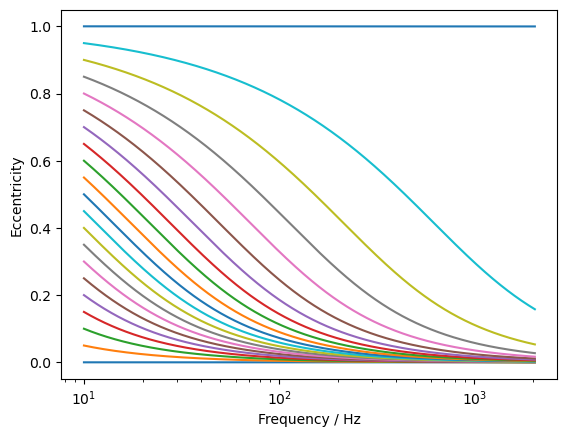

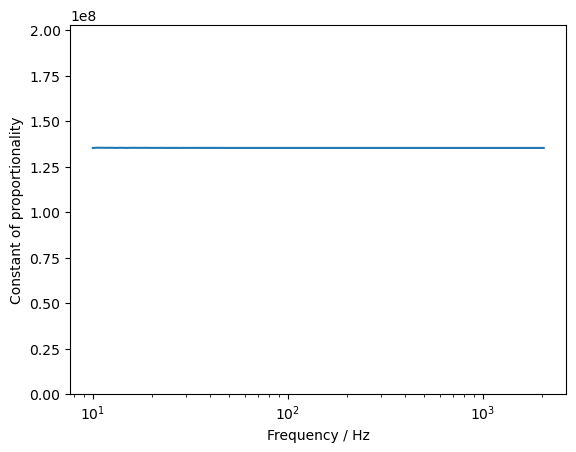

In [26]:
fs = np.linspace(10, 2048, 10**6)
for e in np.linspace(0.00001, 0.99999, 21):
    es = shifted_e(fs, 10, e)
    plt.plot(fs, es)
    plt.xscale('log')
    plt.xlabel('Frequency / Hz')
    plt.ylabel('Eccentricity')
plt.show()

plt.plot(fs, shifted_e_const(fs, es))
plt.ylim(0, 1.5*np.max(shifted_e_const(fs, es)))
plt.xscale('log')
plt.xlabel('Frequency / Hz')
plt.ylabel('Constant of proportionality')
plt.show()

This is quick and seems to be very accurate. By plotting the value of the constant at different frequencies we can see that this is indeed constant, which was often not the case with the old method.

Happy with this, and implementing into simple pe.